### Personality and It's Transformations ###

An analysis of prof. Jordan Peterson's collection of lectures from University of Toronto personality course.

Lectures in video form provided at: https://www.youtube.com/playlist?list=PL22J3VaeABQAOhH1CLMNnMl2R-O1abW1T     |    More about prof. Peterson at https://www.jordanbpeterson.com/

---

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

from constants import *

import umap
import hdbscan
from collections import Counter

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Loading the data</h4> 
</div>

In [3]:
with open(f'{OUTPUT_FOLDER}\{FINAL_CAPTIONS_FILE_NAME}', 'r', encoding='utf-8') as f:
    data = f.readlines()
data = [sent.replace('\n', '') for sent in data]

In [4]:
data[:5]

['Well, after all that.',
 'So, welcome to Psychology 230.',
 'Nice to see you all here.',
 'So, what I’m going to do today—how I’m going to start—is I’m going to give you an overview of the content of the course',
 'and then I’ll give you an overview of the class requirements right at the end.']

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Checking the model</h4> 
</div>

***Sentence-BERT*** - a modification of the pretrained BERT network will be used for sentence embeddings.   
Paper on Sentence-BERT can be found at https://arxiv.org/abs/1908.10084

In [5]:
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

In [6]:
model.max_seq_length

256

The default model has length 256, but it must be increased because our longest sentence has 315 words and the number of tokens will be even greater. A max value of 512 will be set.

In [7]:
model.max_seq_length = SENT_LENGTH

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Embedding</h4> 
</div>

In [8]:
%%time

embeddings = model.encode(data, batch_size=128, convert_to_numpy=True, show_progress_bar=True)

Batches: 100%|██████████| 48/48 [02:05<00:00,  2.61s/it]

Wall time: 2min 5s


In [9]:
print(embeddings.shape, type(embeddings))
embeddings

(6144, 384) <class 'numpy.ndarray'>


array([[-0.042135  , -0.00991856,  0.0509069 , ..., -0.05108282,
         0.00194738,  0.04068652],
       [ 0.00552613, -0.02808623, -0.04600509, ...,  0.05598029,
         0.00492619, -0.03378102],
       [-0.03447534, -0.04569017,  0.06889623, ...,  0.10120902,
         0.02934075,  0.04402328],
       ...,
       [ 0.0612012 ,  0.02968354, -0.00442004, ..., -0.0268718 ,
         0.04280903,  0.10524604],
       [-0.11883845,  0.04829872, -0.00254809, ...,  0.12640946,
         0.04654904, -0.01571726],
       [-0.11883845,  0.04829872, -0.00254809, ...,  0.12640946,
         0.04654904, -0.01571726]], dtype=float32)

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Dimensionality reduction</h4> 
</div>

***UMAP*** is a dimensionality reduction algorytm published in 2020.    
The original paper can be found here: https://arxiv.org/pdf/1802.03426.pdf

In [10]:
neighbors = 10
components = 5

### Training the sample model ###

In [11]:
%%time

umap_embeddings = umap.UMAP(
    n_neighbors = neighbors,
    n_epochs = 5000,
    min_dist = 0.0,
    learning_rate = 0.4,
    verbose = True,
    metric = 'cosine').fit_transform(embeddings)

UMAP(angular_rp_forest=True, learning_rate=0.4, metric='cosine', min_dist=0.0, n_epochs=5000, n_neighbors=10, verbose=True)
Sun Jan  8 16:42:20 2023 Construct fuzzy simplicial set
Sun Jan  8 16:42:20 2023 Finding Nearest Neighbors
Sun Jan  8 16:42:20 2023 Building RP forest with 9 trees
Sun Jan  8 16:42:27 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	 8  /  13
	Stopping threshold met -- exiting after 8 iterations
Sun Jan  8 16:42:54 2023 Finished Nearest Neighbor Search
Sun Jan  8 16:42:57 2023 Construct embedding


Epochs completed: 100%| ██████████ 5000/5000 [01:08]


Sun Jan  8 16:44:06 2023 Finished embedding
Wall time: 1min 46s


In [30]:
print(umap_embeddings.shape, type(umap_embeddings))
embeddings

(6144, 2) <class 'numpy.ndarray'>


array([[-0.042135  , -0.00991856,  0.0509069 , ..., -0.05108282,
         0.00194738,  0.04068652],
       [ 0.00552613, -0.02808623, -0.04600509, ...,  0.05598029,
         0.00492619, -0.03378102],
       [-0.03447534, -0.04569017,  0.06889623, ...,  0.10120902,
         0.02934075,  0.04402328],
       ...,
       [ 0.0612012 ,  0.02968354, -0.00442004, ..., -0.0268718 ,
         0.04280903,  0.10524604],
       [-0.11883845,  0.04829872, -0.00254809, ...,  0.12640946,
         0.04654904, -0.01571726],
       [-0.11883845,  0.04829872, -0.00254809, ...,  0.12640946,
         0.04654904, -0.01571726]], dtype=float32)

### Saving the model ###

In [26]:
with open(f'{MODELS_FOLDER}\{SAMPLE_UMAP_MODEL_NAME}.npy', 'wb') as f:
    np.save(f, umap_embeddings)

In [27]:
with open(f'{MODELS_FOLDER}\{SAMPLE_UMAP_MODEL_NAME}.npy', 'rb') as f:
    umap_model = np.load(f)

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Clustering</h4> 
</div>

***HDBSCAN*** is a hierarchical clustering algorithm. It returns a good enough clustering straight away with little parameter tuning.   
More information can be found here:
https://nbviewer.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb  
Link to offical repository: https://github.com/scikit-learn-contrib/hdbscan 

And comparison between DBSCAN and other clustering methods: https://nbviewer.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb


In [33]:
min_cluser_size = 60
min_samples = 3

In [39]:
%%time

clusters = hdbscan.HDBSCAN(
    min_cluster_size = min_cluser_size,
    metric = 'euclidean',
    min_samples = min_samples,
    cluster_selection_epsilon = 0.1,
    cluster_selection_method = 'leaf',
    leaf_size = 35,
    algorithm = 'best').fit(umap_embeddings)


Wall time: 241 ms


In [114]:
def cluster_statistics(clusters:hdbscan.hdbscan_.HDBSCAN):
    summary = pd.DataFrame(columns = ['metric', 'value'])
    summary.at[0, 'metric'] = 'Number of unique clusters'
    summary.at[0, 'value'] = len(set(clusters.labels_))

    cnt = Counter()
    cnt.update(clusters.labels_)

    sum_of_all_elements = sum([entry[1] for entry in cnt.most_common()])
    sum_of_empty_elements = [entry[1] for entry in cnt.most_common() if entry[0] == -1][0]


    summary.at[1, 'metric'] = 'Number of all sentences'
    summary.at[1, 'value'] = sum_of_all_elements
    
    summary.at[2, 'metric'] = 'Number of noise'
    percentage = '{:.4}'.format(str((sum_of_empty_elements/sum_of_all_elements)*100))
    summary.at[2, 'value'] = f'{sum_of_empty_elements} ({percentage}%)'

    summary
    x, y= zip(*cnt.most_common())
    plt.bar(x, y);
    
    return summary

,metric,value
0,Number of unique clusters,34
1,Number of all sentences,6144
2,Number of noise,2035 (33.1%)


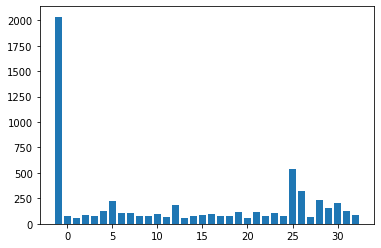

In [115]:
cluster_statistics(clusters)

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Visualisation</h4> 
</div>

In [119]:
%%time

umap_3d = umap.UMAP(
    n_neighbors = neighbors,
    n_components = 3,
    min_dist = 0.5,
    n_epochs = 9000,
    learning_rate = 0.4,
    metric = 'cosine').fit_transform(embeddings)

Wall time: 2min 40s


In [120]:
umap_3d

array([[-10.255381 ,  -0.7764898,  11.232977 ],
       [-11.237078 ,  -4.3988147,  17.254658 ],
       [-10.759359 ,  -0.4573234,  11.018052 ],
       ...,
       [-11.449824 ,  -2.2520685,  12.606069 ],
       [ -9.170087 ,  -0.5147373,   9.051618 ],
       [ -9.340469 ,  -0.5771049,   9.162561 ]], dtype=float32)